# LRP (Layer-wise Relevance Propagation)

**idea**: A method that helps understanding why a NN made a certain prediction. It goes backwards (propagating "relevance scores" backward) from the output (e.g. "cat" image prediction) to figure out which parts of the input were most responsible for that decision. 

In [1]:
!pip install tensorflow keras innvestigate matplotlib

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/284.2 MB ? eta -:--:--
    --------------------------------------- 6.6/284.2 MB 31.0 MB/s eta 0:00:09
   -- ------------------------------------- 14.7/284.2 MB 35.5 MB/s eta 0:00:08
   -- ------------------------------------- 19.9/284.2 MB 32.3 MB/s eta 0:00:09
   --- ------------------------------------ 26.2/284.2 MB 31.3 MB/s eta 0:00:09
   ---- ----------------------------------- 29.4/284.2 MB 28.6 MB/s eta 0:00:09
   ----- ---------------------------------- 37.2/284.2 MB 29.6 MB/s eta 0:00:09
   ------ --------------------------------- 45.1/284.2 MB 31.2 MB/s eta 0:00:08
   ------- -------------------------------- 51.6/284.2 MB 30.7 MB/s eta 0:00:08
   -------- ------------------------------- 58.7/284.2 MB 31.7 MB/s eta 0:00:08
   -------- ------------------------------- 61.1/284.2 MB 2

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.14.1 which is incompatible.


In [41]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.utils import to_categorical
import innvestigate

In [42]:
# Load and preprocess MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [43]:
# Define a simple model with sofmax
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation="relu"),
    Dense(10),
    Activation("softmax")
])

In [44]:
# Compile and train
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(x_train, y_train, epochs=3, batch_size=128, validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/3
54000/54000 [==============================] - 1s 14us/sample - loss: 0.3870 - accuracy: 0.8941 - val_loss: 0.1788 - val_accuracy: 0.9525
Epoch 2/3
 9856/54000 [====>.........................] - ETA: 0s - loss: 0.2023 - accuracy: 0.9438

C:\Users\fbagi\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


54000/54000 [==============================] - 1s 12us/sample - loss: 0.1776 - accuracy: 0.9495 - val_loss: 0.1264 - val_accuracy: 0.9658
Epoch 3/3
54000/54000 [==============================] - 1s 12us/sample - loss: 0.1275 - accuracy: 0.9640 - val_loss: 0.0994 - val_accuracy: 0.9733


In [45]:
# strip the softmax for analysis (innvestigate requires this)
model_wo_softmax = Model(inputs=model.input, outputs=model.layers[-2].output)

In [46]:
# Create analyzer (LRP-epsilon rule)
analyzer = innvestigate.create_analyzer("lrp.epsilon", model_wo_softmax)

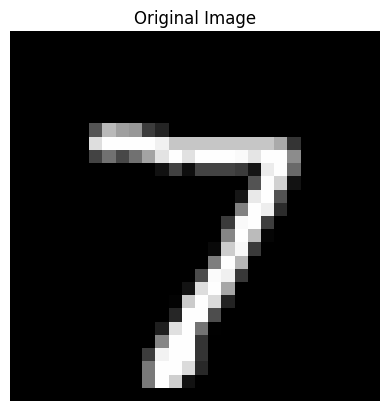

In [47]:
# 5. Choose an image to explain
image = x_test[0:1]
plt.imshow(image[0], cmap="gray")
plt.title("Original Image")
plt.axis("off")
plt.show()

In [48]:
# 6. Analyze relevance
relevance = analyzer.analyze(image)

C:\Users\fbagi\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [50]:
# if the relevance shape is (1, 28, 28), squeeze out the batch dimension
heatmap = relevance.squeeze()

In [53]:
# if the heatmap is 1D (e.g., 784,) reshape it
if heatmap.ndim == 1 and heatmap.shape[0] == 784:
    heatmap = heatmap.reshape(28, 28)

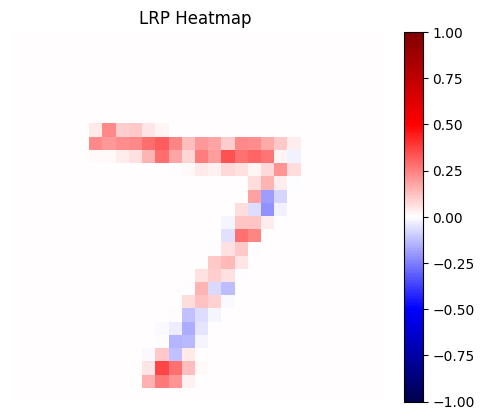

In [54]:
# 7. Visualize
plt.imshow(heatmap, cmap="seismic", vmin=-1, vmax=1)
plt.title("LRP Heatmap")
plt.colorbar()
plt.axis('off')
plt.show()